<a href="https://colab.research.google.com/github/PondKann/CXR-Project/blob/main/Segment%20Dog%20img%20by%20U-net.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git

    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
!pip install tensorflow_datasets

In [ ]:
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf

from tensorflow_examples.models.pix2pix import pix2pix

import tensorflow_datasets as tfds
tfds.disable_progress_bar()

from IPython.display import clear_output
import matplotlib.pyplot as plt

In [ ]:
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4LCL2Q/oxford_iiit_pet-train.tfrecord
Shuffling and writing examples to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0.incomplete4LCL2Q/oxford_iiit_pet-test.tfrecord
Dataset oxford_iiit_pet downloaded and prepared to /root/tensorflow_datasets/oxford_iiit_pet/3.2.0. Subsequent calls will reuse this data.


รหัสต่อไปนี้ทำการพลิกภาพอย่างง่าย นอกจากนี้ รูปภาพยังถูกทำให้เป็นมาตรฐานเป็น [0,1] สุดท้าย ตามที่กล่าวไว้ข้างต้น พิกเซลในมาสก์การแบ่งส่วนจะมีป้ายกำกับว่า {1, 2, 3} เพื่อความสะดวก ให้ลบ 1 ออกจากตัวพรางการแบ่งกลุ่ม จะได้ป้ายกำกับว่า : {0, 1, 2}

In [ ]:
def normalize(input_image, input_mask):
  input_image = tf.cast(input_image, tf.float32) / 255.0
  input_mask -= 1
  return input_image, input_mask

In [ ]:
@tf.function
def load_image_train(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))

  if tf.random.uniform(()) > 0.5:
    input_image = tf.image.flip_left_right(input_image)
    input_mask = tf.image.flip_left_right(input_mask)

  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

In [ ]:
def load_image_test(datapoint):
  input_image = tf.image.resize(datapoint['image'], (128, 128))
  input_mask = tf.image.resize(datapoint['segmentation_mask'], (128, 128))
  input_image, input_mask = normalize(input_image, input_mask)
  return input_image, input_mask

ชุดข้อมูลมีการแบ่งการทดสอบและการฝึกที่จำเป็นอยู่แล้ว ดังนั้นเรามาใช้การแยกเดียวกันต่อไป

In [ ]:
TRAIN_LENGTH = info.splits['train'].num_examples
BATCH_SIZE = 64
BUFFER_SIZE = 1000
STEPS_PER_EPOCH = TRAIN_LENGTH 

In [ ]:
train = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
test = dataset['test'].map(load_image_test)

In [ ]:
train_dataset = train.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_dataset = test.batch(BATCH_SIZE)

In [ ]:
def display(display_list):
  plt.figure(figsize=(15, 15))

  title = ['Input Image', 'True Mask', 'Predicted Mask']

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(title[i])
    plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
    plt.axis('off')
  plt.show()

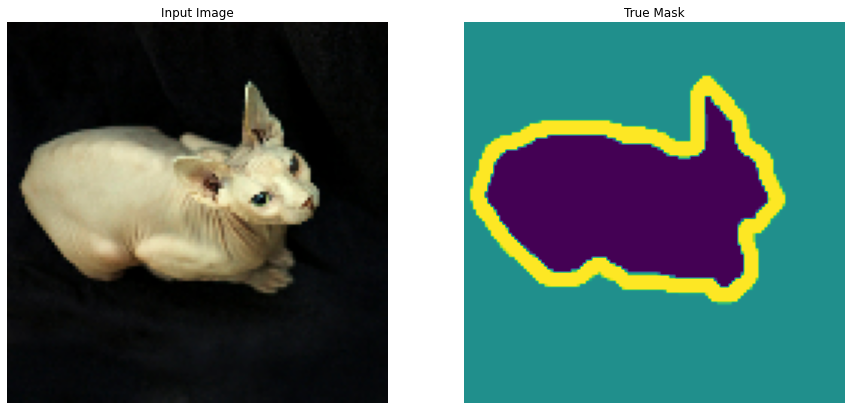

In [ ]:
for image, mask in train.take(1):
  sample_image, sample_mask = image, mask
display([sample_image, sample_mask])

ถึงเวลากำหนดแบบจำลอง
โมเดลที่ใช้ในที่นี้คือ U-Net ที่ดัดแปลง U-Net ประกอบด้วยตัวเข้ารหัส (ตัวสุ่มตัวอย่าง) และตัวถอดรหัส (ตัวขยายสัญญาณ) เพื่อที่จะเรียนรู้คุณลักษณะที่มีประสิทธิภาพ และลดจำนวนพารามิเตอร์ที่ฝึกได้ จึงสามารถใช้แบบจำลองที่ได้รับการฝึกอบรมล่วงหน้าเป็นตัวเข้ารหัสได้ ดังนั้น ตัวเข้ารหัสสำหรับงานนี้จะเป็นโมเดล MobileNetV2 ที่ได้รับการฝึกอบรมล่วงหน้า

In [ ]:
OUTPUT_CHANNELS = 3

เหตุผลในการส่งออกสามช่องสัญญาณเนื่องจากมีป้ายกำกับที่เป็นไปได้สามป้ายสำหรับแต่ละพิกเซล คิดว่านี่เป็นการจัดประเภทหลายชั้น โดยที่แต่ละพิกเซลถูกแบ่งออกเป็นสามชั้น

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)
# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
layers = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=layers)
down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


ตัวถอดรหัส/ตัวขยายสัญญาณเป็นเพียงชุดของบล็อกตัวอย่างที่นำมาใช้ในตัวอย่าง TensorFlow

In [ ]:
up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

Defining the Unet

In [ ]:
def unet_model(output_channels):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3])
  x = inputs

  # Downsampling through the model
  skips = down_stack(x)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)
  return tf.keras.Model(inputs=inputs, outputs=x)

Let's Train the model

In [ ]:
model = unet_model(OUTPUT_CHANNELS)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

ดูสถาปัตยกรรมแบบจำลองที่เกิดขึ้นอย่างรวดเร็ว

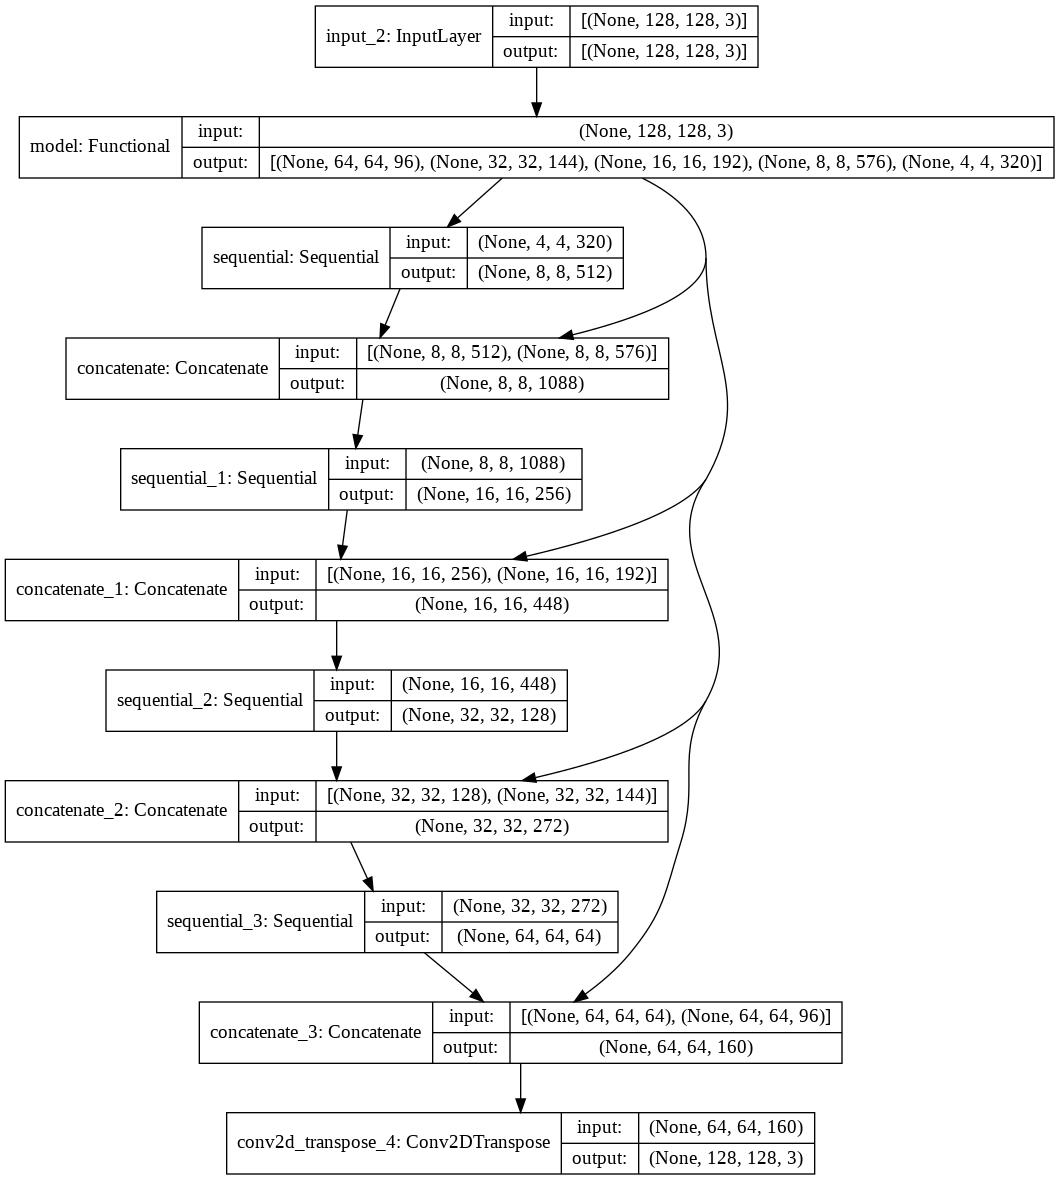

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

Let's try out the model to see what it predicts before training. มาลองใช้โมเดลกันก่อนว่าทำนายอะไรบ้าง

In [ ]:
def create_mask(pred_mask):
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0]

In [ ]:
def show_predictions(dataset=None, num=1):
  if dataset:
    for image, mask in dataset.take(num):
      pred_mask = model.predict(image)
      display([image[0], mask[0], create_mask(pred_mask)])
  else:
    display([sample_image, sample_mask,
             create_mask(model.predict(sample_image[tf.newaxis, ...]))])

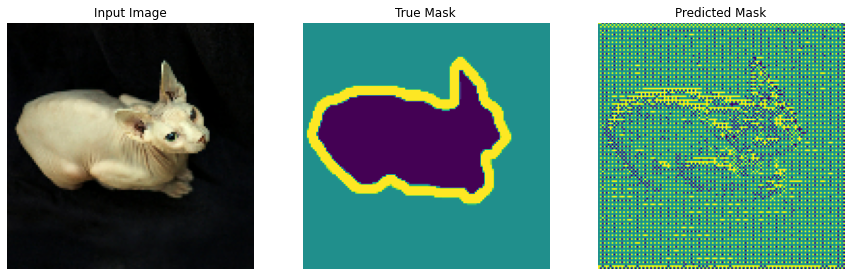

In [ ]:
show_predictions()

มาดูกันว่าโมเดลนี้พัฒนาขึ้นอย่างไรในขณะที่กำลังฝึก เพื่อให้งานนี้สำเร็จ ฟังก์ชันเรียกกลับถูกกำหนดไว้ด้านล่าง

In [ ]:
class DisplayCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    clear_output(wait=True)
    show_predictions()
    print ('\nSample Prediction after epoch {}\n'.format(epoch+1))

In [ ]:
EPOCHS = 3
VAL_SUBSPLITS = 5
VALIDATION_STEPS = info.splits['test'].num_examples

model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset,
                          callbacks=[DisplayCallback()])

Epoch 1/3
 106/3680 [..............................] - ETA: 5:09:10 - loss: 0.3584 - accuracy: 0.8584